# Sentiment Analysis with Keras Deep Learning

## Credits
Thanks to the folks at [machinelearningmastery.com](machinelearningmastery.com) for their tutorial on Sentiment Analysis for Keras Deep Learning. You can find the [original tutorial here](http://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/#comment-386724).

## Purpose
My aim is to follow the tutorial and repackage it as a ready-to-go iPython notebook. That way, anyone can pull the code and interact with it without ever even leaving the tutorial. I will also provide my insights and "what I learned" as well. In this demo, I am also bringing the code up to date a bit. 

## Environment
This notebook was written in Jupyter along with:
* Python 3.5.2 :: Anaconda 4.1.1 (x86_64)
* Keras (1.2.1)
* tensorflow (0.12.1)
* numpy (1.11.2)
* matplotlib (1.5.3)

## Overview

We start with a quick visualization of the IMDB dataset, then we build two simple models one without convolutions and then one with convolutions.

### Visualization & Background
In this section of the tutorial, we write some code to better understand the dataset. 

#### About the Dataset
In this case we are working with the IMDB (Internet Movie DataBase) which includes thousands of move reviews in plain text. You can [find it on Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) if you are interested in submitting your results. The words in the dataset are encoded as numbers based on their absolute popularity.

The labels for the dataset are just 0 and 1 representing whether or not the review was positive.

#### Imports
As usual, we need to set matplotlib to be inline for our notebook format and import the necessary libraries.

In [1]:
%matplotlib inline
import numpy
from keras.datasets import imdb
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


#### Reproducability
A recurring theme in data science and tutorials at [machinelearningmastery.com](machinelearningmastery.com) is reproducible research. One good rule of thumb is to initialize a random seed so that researches can repeat the same experiments.

In [2]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

#### Get the Data
Now that we have everything set up, let's import the data set. Since we just want a summary of the whole data set, we can merge the train and test sets.

In [3]:
# load the dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = numpy.concatenate((X_train, X_test), axis=0)
y = numpy.concatenate((y_train, y_test), axis=0)

#### Summarize the Data
Let's examine the dimensions, the number of possible labels (classes), the total number of unique words, and the average length of the reviews and their standard deviation.

In [4]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

# Summarize number of classes
print("Classes: ")
print(numpy.unique(y))

# Summarize number of words
print("Number of words: ")
print(len(numpy.unique(numpy.hstack(X))))

# Summarize review length
print("Review length: ")
result = list(map(len, X))
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))

Training data: 
(50000,)
(50000,)
Classes: 
[0 1]
Number of words: 
88585
Review length: 
Mean 234.76 words (172.911495)


#### Visualize the Data
We can get a better understanding of the distribution of word usage. When you look at the plot, you can see that some reviews are extremely long but they are certainly outliers. The majority appear to be somewhere just above 500. We can take advantage of that later to save time in training and to prevent overfitting to outliers.

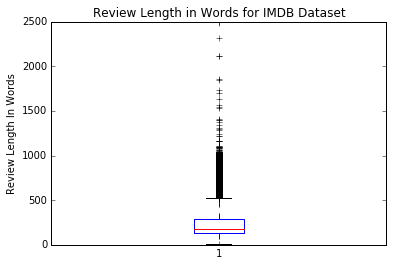

In [5]:
# plot review length
pyplot.boxplot(result)
pyplot.title('Review Length in Words for IMDB Dataset') # subplot 211 title
pyplot.ylabel("Review Length In Words")
pyplot.show()

### Preprocessing & Word Embedding
To preprocess, we are going to select only the most used words. We can use the nb_words parameter to tune this threshold. Tuning this treshold allows one to get the most value out of training on the least data necessary. Depending on the dataset, you might need to be careful about the value of individual words (eg cerebral, hilarious, Nicholas Cage vs. I, the, and movie).

The article introduces a technique known as word embedding. In this process we are not just converting words to numbers but specifically to real-valued numbers. We can achieve this with Keras by adding an Embedding layer. We can specify the shape of the embeddings as well. Converting the review text into real-valued numbers enables us to train a neural network just like any other.

It is important to note that we will truncate any large reviews and pad any small reviews.

In [6]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)

In [7]:
# Pad the small reviews
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

### Baseline Model

#### Define the Model and Compile to Backend
Here is the critical code for Keras to build the net. We have a boilerplate Sequential() object to which we add() several layers including the aforementioned Embedding() as well as a Flatten() layer, a hidden Dense() layer, and a single Dense() output for a positive/negative review.

In [8]:
# create the model
model = Sequential()
# Note the word embeddings
model.add(Embedding(top_words, 32, input_length=max_words))
# Flatten (or unroll) takes us from a 2D matrix (32x500) to 1D vector (1x32*500)
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We can actually print out a description of the model object with summary(). Pretty handy! Maybe one day it will even print out a diagram of the network.

In [9]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 16000)         0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 250)           4000250     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             251         dense_1[0][0]                    
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_______________

#### Train/Fit the Model
This step takes a few seconds to a few minutes to get an accuracy around 87%. I would love to see a comparison to human ability for this one as some reviews could be difficult to understand and would obviously take much much longer for a person.

In [10]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=0)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.35%


#### Results of Baseline Model
Our results are promising. It is possible to imagine that with additional tuning of the word embeddings and neural network architecture, we might be able to achieve even better results.

### Improving the Model
Now that we have a baseline, we can experiment with other techniques. We are going to see what happens when we add a convolution. More information about convolutions can be found at [machinelearningmastery.com](machinelearningmastery.com) as well as this GitHub repo.

#### Define the Model and Compile to Backend
The model is essentially the same but we also apply a Convolution1D() layer and a MaxPooling1D() layer. The pooling layer is akin to dimensionality reduction. Intuitively, we can think of it as a way to take only the relevant information gleaned from convolution and discarding the excess.

In [11]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 500, 32)       160000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 500, 32)       3104        embedding_2[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 250, 32)       0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 8000)          0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

#### Training the Model
This will take several minutes longer than the baseline model.

In [12]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=0)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.38%


#### Results of Applying Convolutions
In the end, we can see at least a small improvement by using convolutions. Our author attributes the improvement from convolution to the concept of sequences within the text much like sequences/patterns in image features which conv-nets are known to be good at learning.

### Conclusion

In this tutorial we applied two different neural nets to movie reviews to determine if they were positive or negative with promising results. Many thanks to [machinelearningmastery.com](machinelearningmastery.com) for their well-written tutorials and (working) code examples! 